In [1]:
# Cell 1: Imports and Settings
%matplotlib inline

import numpy as np
import pylab as py
import os
from sklearn.utils import shuffle
from sklearn.svm import SVC, LinearSVC

# Global Settings
main_dir = os.getcwd() + r'\\'
FIGURE_SIZE = (8, 10)
DPI = 150
LABEL = [-1, 0, 1]
LABEL_LEGEND = ['loss', 'draw', 'win']


In [2]:
# Cell 2: Igor Output Function
def generate_igor(x_label, x_data, y_label, y_data, plot_save):
    if not x_label and not x_data and not y_label and not y_data:
        return None

    igor_save = plot_save[:-3] + 'itx'
    with open(igor_save, 'w') as data:
        for L in [x_label, y_label]:
            for i in range(len(L)):
                L[i] = '\'' + L[i] + '\''
        s_return = 'IGOR\rWAVES/D\t'
        s_label = '\t'.join(str(e) for e in x_label) + '\t' + '\t'.join(str(e) for e in y_label)
        s_return += s_label + '\rBEGIN\r'

        if type(x_data) != list:
            x_data = x_data.tolist()
        if type(y_data) != list:
            y_data = y_data.tolist()
        L_data = x_data + y_data
        L_size = [len(ld) for ld in L_data]

        max_i = max(L_size)
        length = len(L_size)
        for i in range(max_i):
            s_i = ''
            for j in range(length):
                s_i += '\t' + str(L_data[j][i]) if L_size[j] > i and L_data[j][i] is not None else '\tNAN'
            s_return += s_i + '\r'
        s_return += 'END'
        data.write(s_return)


In [3]:
# Cell 3: Utility Functions
def add_x0(x):
    return np.hstack([np.ones((x.shape[0], 1)), x])

def define_xy(data, feature_idx, ratio=0.8, add_zero=True):
    x = add_x0(data[:, feature_idx]) if add_zero else data[:, feature_idx]
    y = data[:, -1]
    i_split = int(len(y) * ratio)
    return x[:i_split, :], y[:i_split], x[i_split:, :], y[i_split:]


In [4]:
# Cell 4: SVM Plot Function
def plot_SVM(x0, x1, kernel_type, x, y, x_train, y_train, n_poly=3, title=None, figsize=FIGURE_SIZE, dpi=DPI):
    # Use LinearSVC for linear kernel to speed up
    if kernel_type == 'linear':
        clf = LinearSVC(max_iter=5000)
    else:
        clf = SVC(kernel=kernel_type, degree=n_poly if kernel_type == 'poly' else 3)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x)

    # Accuracy & precision/recall
    accuracy = np.mean(y_pred == y)
    p_win = np.mean(y_pred[y_pred == 1] == y[y_pred == 1])
    p_draw = np.mean(y_pred[y_pred == 0] == y[y_pred == 0])
    p_loss = np.mean(y_pred[y_pred == -1] == y[y_pred == -1])
    r_win = np.sum(y_pred[y_pred == 1] == y[y_pred == 1]) / np.sum(y == 1)
    r_draw = np.sum(y_pred[y_pred == 0] == y[y_pred == 0]) / np.sum(y == 0)
    r_loss = np.sum(y_pred[y_pred == -1] == y[y_pred == -1]) / np.sum(y == -1)

    print(f'{title}')
    print(f'Overall Accuracy: {accuracy:.3f}')
    print(f'Win/Draw/Loss Precision: {[p_win, p_draw, p_loss]}')
    print(f'Win/Draw/Loss Recall: {[r_win, r_draw, r_loss]}')

    # Plotting
    fig, ax = py.subplots(2, 2, figsize=figsize, dpi=dpi)
    titles = ['Total Prediction', 'Actual Values', 'Correct Predictions', 'Incorrect Predictions']
    for i in range(2):
        for j in range(2):
            ax[i, j].set_xlabel('home_average_rating')
            ax[i, j].set_ylabel('away_average_rating')

    ax[0,0].scatter(x0, x1, c=y_pred, cmap=py.cm.coolwarm, s=20, edgecolors='k')
    ax[0,0].set_title(titles[0])
    ax[0,1].scatter(x0, x1, c=y, cmap=py.cm.coolwarm, s=20, edgecolors='k')
    ax[0,1].set_title(titles[1])
    ax[1,0].scatter(x0[y_pred==y], x1[y_pred==y], c=y[y_pred==y], cmap=py.cm.coolwarm, s=20, edgecolors='k')
    ax[1,0].set_title(titles[2])
    ax[1,1].scatter(x0[y_pred!=y], x1[y_pred!=y], c=y[y_pred!=y], cmap=py.cm.coolwarm, s=20, edgecolors='k')
    ax[1,1].set_title(titles[3])

    if title:
        py.suptitle(title)
        py.show()
        generate_igor(
            ['x0','x0_win','x0_draw','x0_loss','x0_correct','x0_wrong',
             'x1','x1_win','x1_draw','x1_loss','x1_correct','x1_wrong'],
            [x0, x0[y==1], x0[y==0], x0[y==-1], x0[y_pred==y], x0[y_pred!=y],
             x1, x1[y==1], x1[y==0], x1[y==-1], x1[y_pred==y], x1[y_pred!=y]],
            ['y_label','y_predict','y_predict_correct','y_predict_wrong'],
            [y+1, y_pred+1, y[y_pred==y]+1, y[y_pred!=y]+1],
            title+'.png'
        )
    return y, y_pred


In [5]:
# Cell 5: Load Data and Split
ratio = 0.8
data_name = main_dir+'match_vectors_extended.csv'
data = shuffle(np.genfromtxt(data_name, delimiter=',', skip_header=1), random_state=0)
x = data[:, :-1]
y = data[:, -1]

# Roster ratings for plotting
data_roster_name = main_dir+'match_vectors.csv'
data_roster = shuffle(np.genfromtxt(data_roster_name, delimiter=',', skip_header=1), random_state=0)
x0 = data_roster[:, 0]
x1 = data_roster[:, 1]

i_split = int(len(y) * ratio)
x_train, y_train = x[:i_split, :], y[:i_split]
x_test, y_test = x[i_split:, :], y[i_split:]
x0_train, x1_train = x0[:i_split], x1[:i_split]
x0_test, x1_test = x0[i_split:], x1[i_split:]


c:\Users\Pratheek\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Pratheek\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SVM_F3, a_roster vs h_roster, rbf, training set
Overall Accuracy: 0.569
Win/Draw/Loss Precision: [np.float64(0.5699481865284974), np.float64(nan), np.float64(0.5654565456545655)]
Win/Draw/Loss Recall: [np.float64(0.8667621776504298), np.float64(0.0), np.float64(0.578177727784027)]


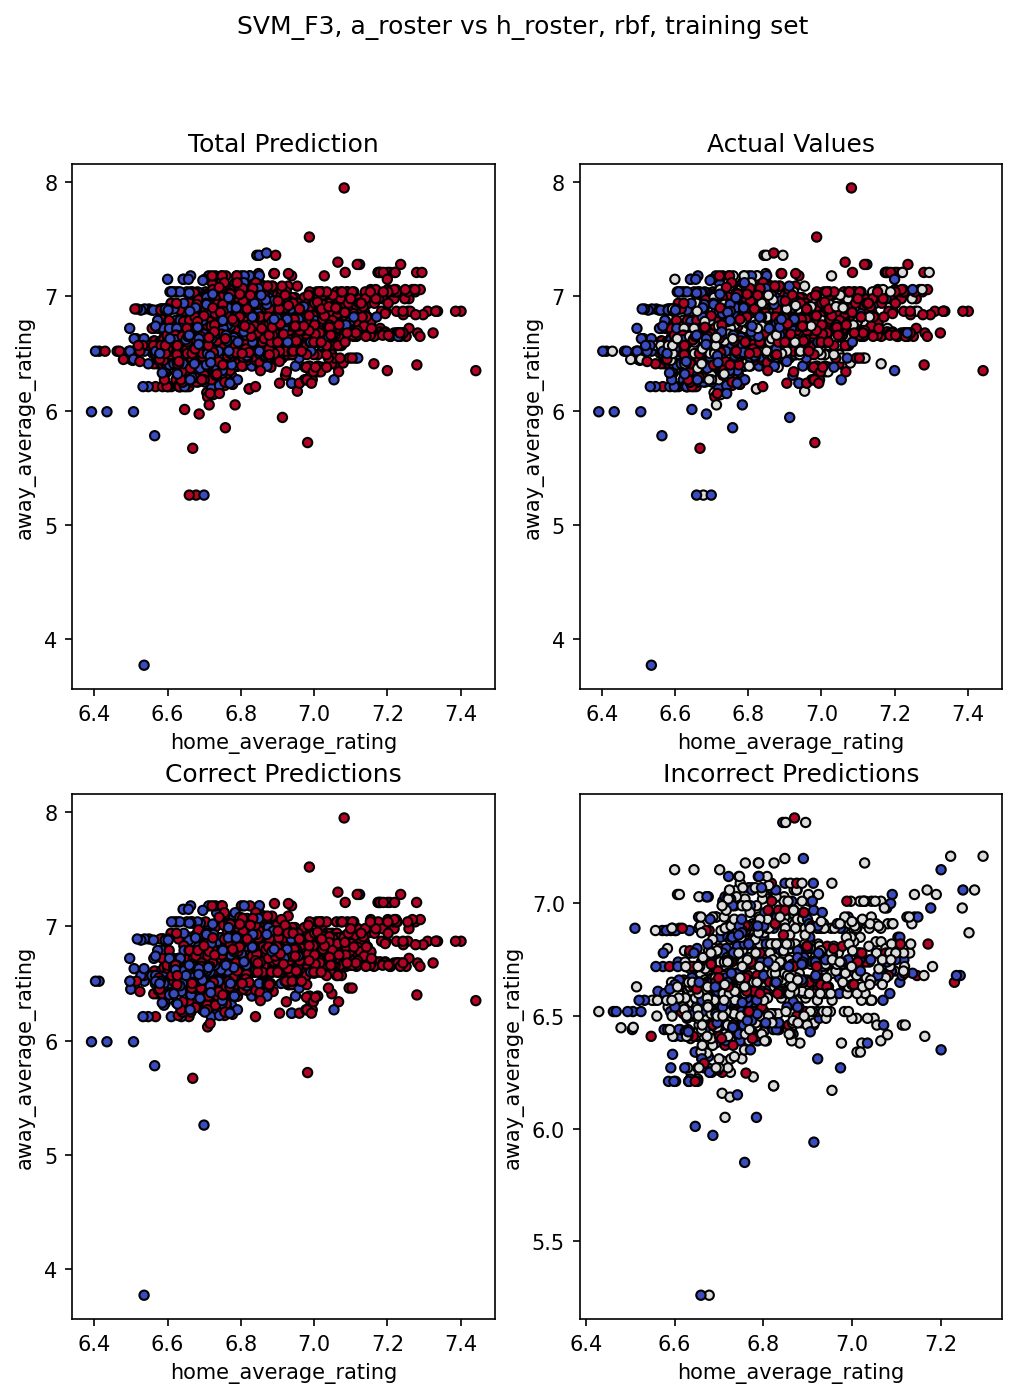

c:\Users\Pratheek\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Pratheek\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SVM_F3, a_roster vs h_roster, rbf, test set
Overall Accuracy: 0.552
Win/Draw/Loss Precision: [np.float64(0.5733082706766918), np.float64(nan), np.float64(0.5022026431718062)]
Win/Draw/Loss Recall: [np.float64(0.8591549295774648), np.float64(0.0), np.float64(0.5402843601895735)]


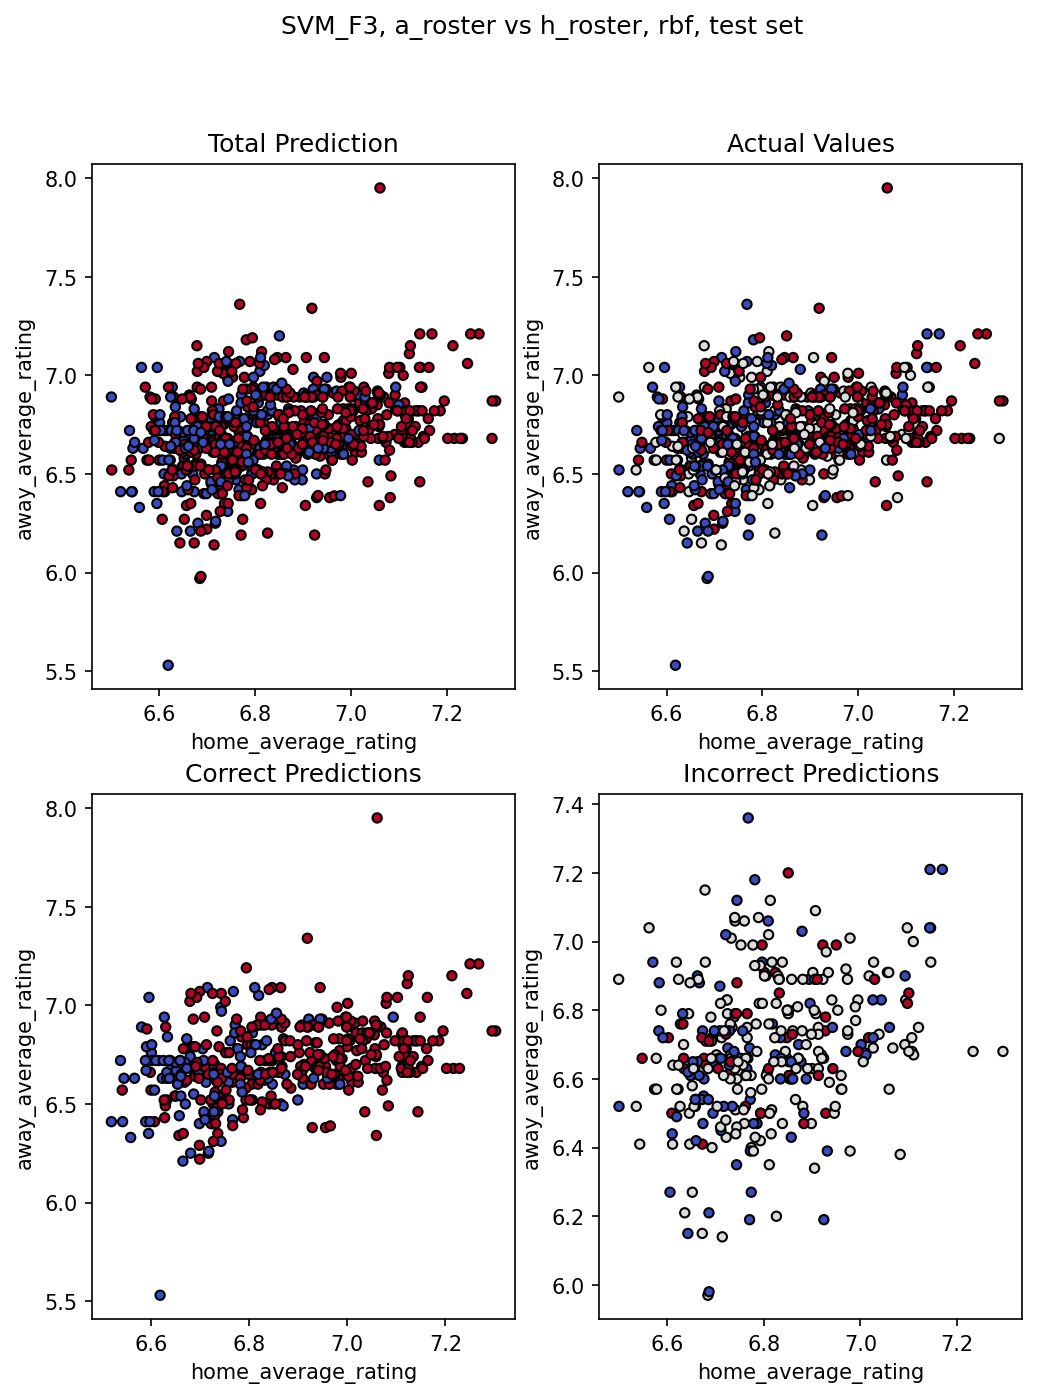

SVM_F3, a_roster vs h_roster, linear, training set
Overall Accuracy: 0.639
Win/Draw/Loss Precision: [np.float64(0.6622781911848884), np.float64(0.5408805031446541), np.float64(0.6277145811789038)]
Win/Draw/Loss Recall: [np.float64(0.8287965616045845), np.float64(0.23025435073627845), np.float64(0.6827896512935883)]


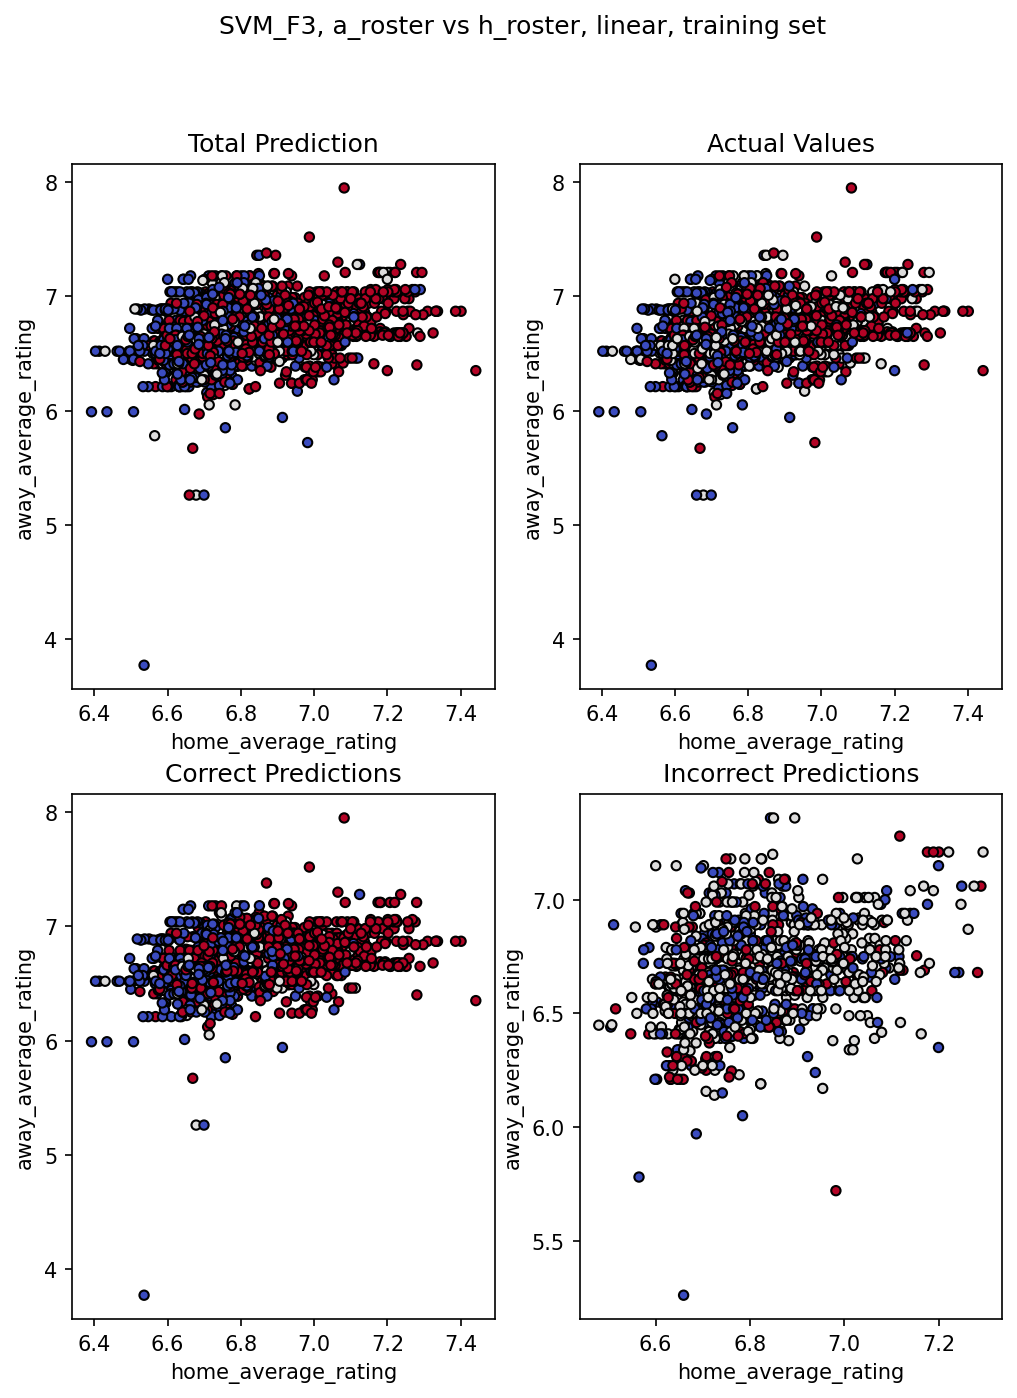

SVM_F3, a_roster vs h_roster, linear, test set
Overall Accuracy: 0.552
Win/Draw/Loss Precision: [np.float64(0.6057906458797327), np.float64(0.34782608695652173), np.float64(0.5103734439834025)]
Win/Draw/Loss Recall: [np.float64(0.7661971830985915), np.float64(0.12435233160621761), np.float64(0.5829383886255924)]


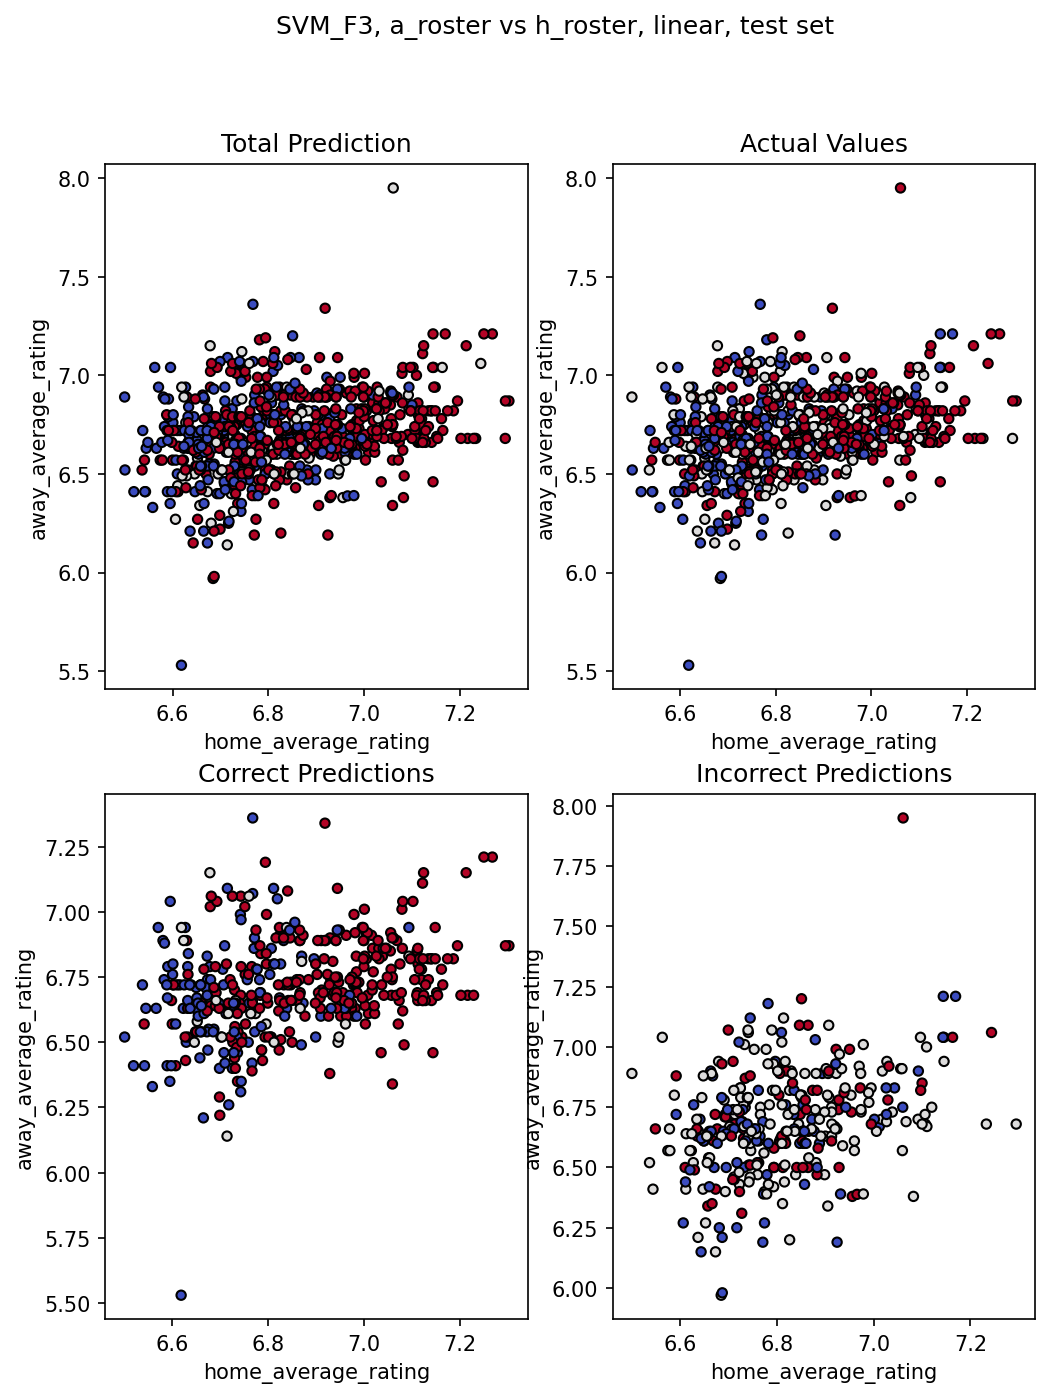

SVM_F3, a_roster vs h_roster, poly_d5, training set
Overall Accuracy: 0.601
Win/Draw/Loss Precision: [np.float64(0.5903671912255604), np.float64(0.8333333333333334), np.float64(0.6159014557670772)]
Win/Draw/Loss Recall: [np.float64(0.8868194842406877), np.float64(0.04685408299866131), np.float64(0.6186726659167604)]


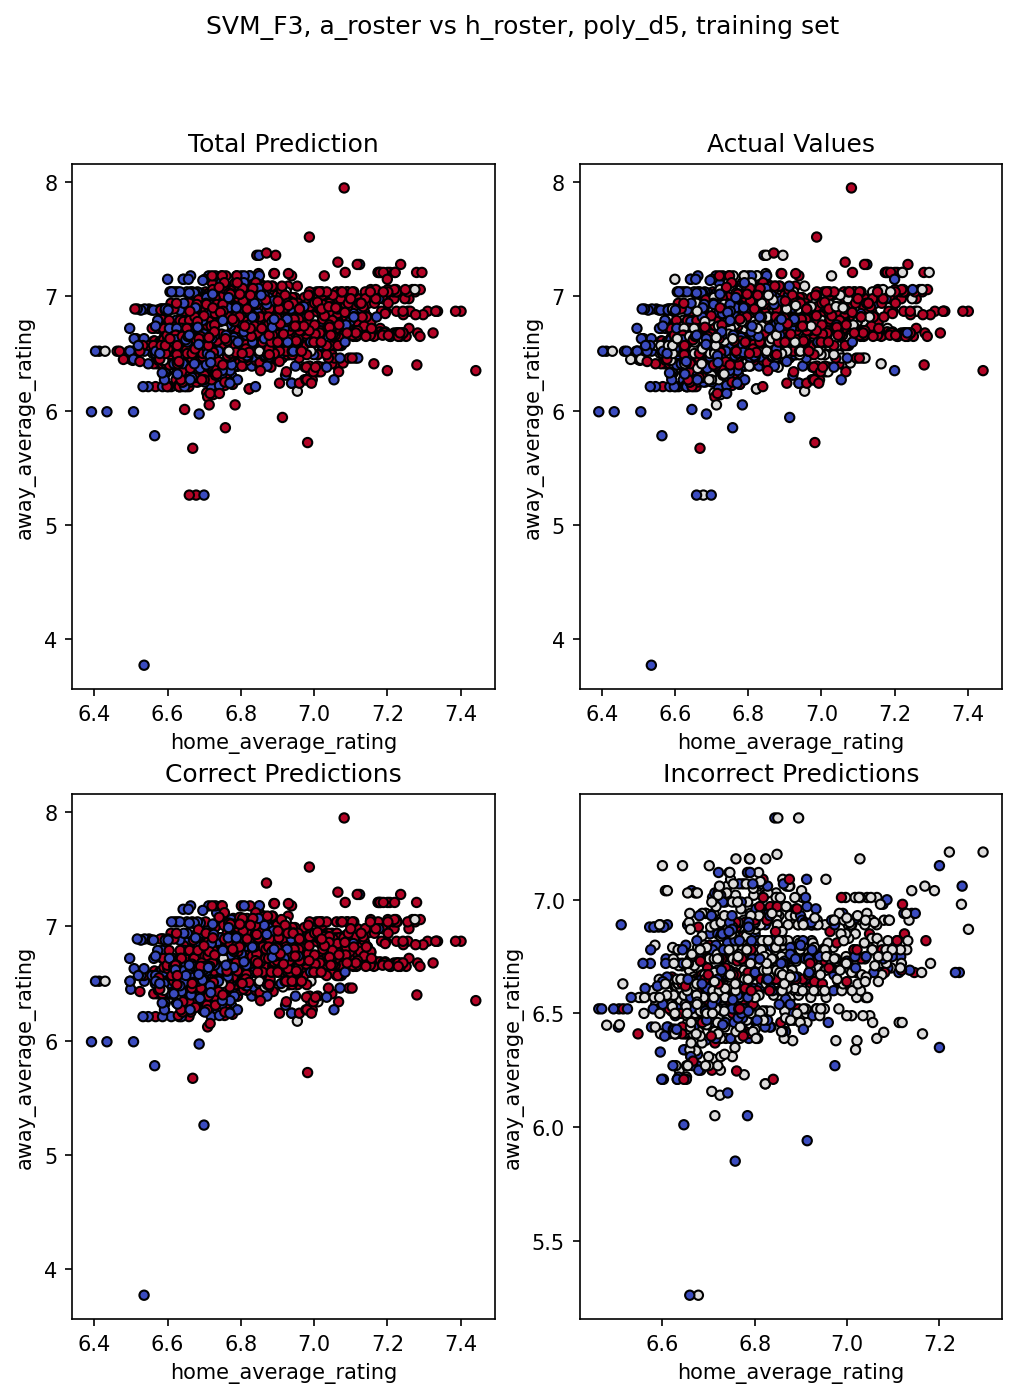

SVM_F3, a_roster vs h_roster, poly_d5, test set
Overall Accuracy: 0.561
Win/Draw/Loss Precision: [np.float64(0.5757575757575758), np.float64(0.14285714285714285), np.float64(0.5401785714285714)]
Win/Draw/Loss Recall: [np.float64(0.856338028169014), np.float64(0.0051813471502590676), np.float64(0.5734597156398105)]


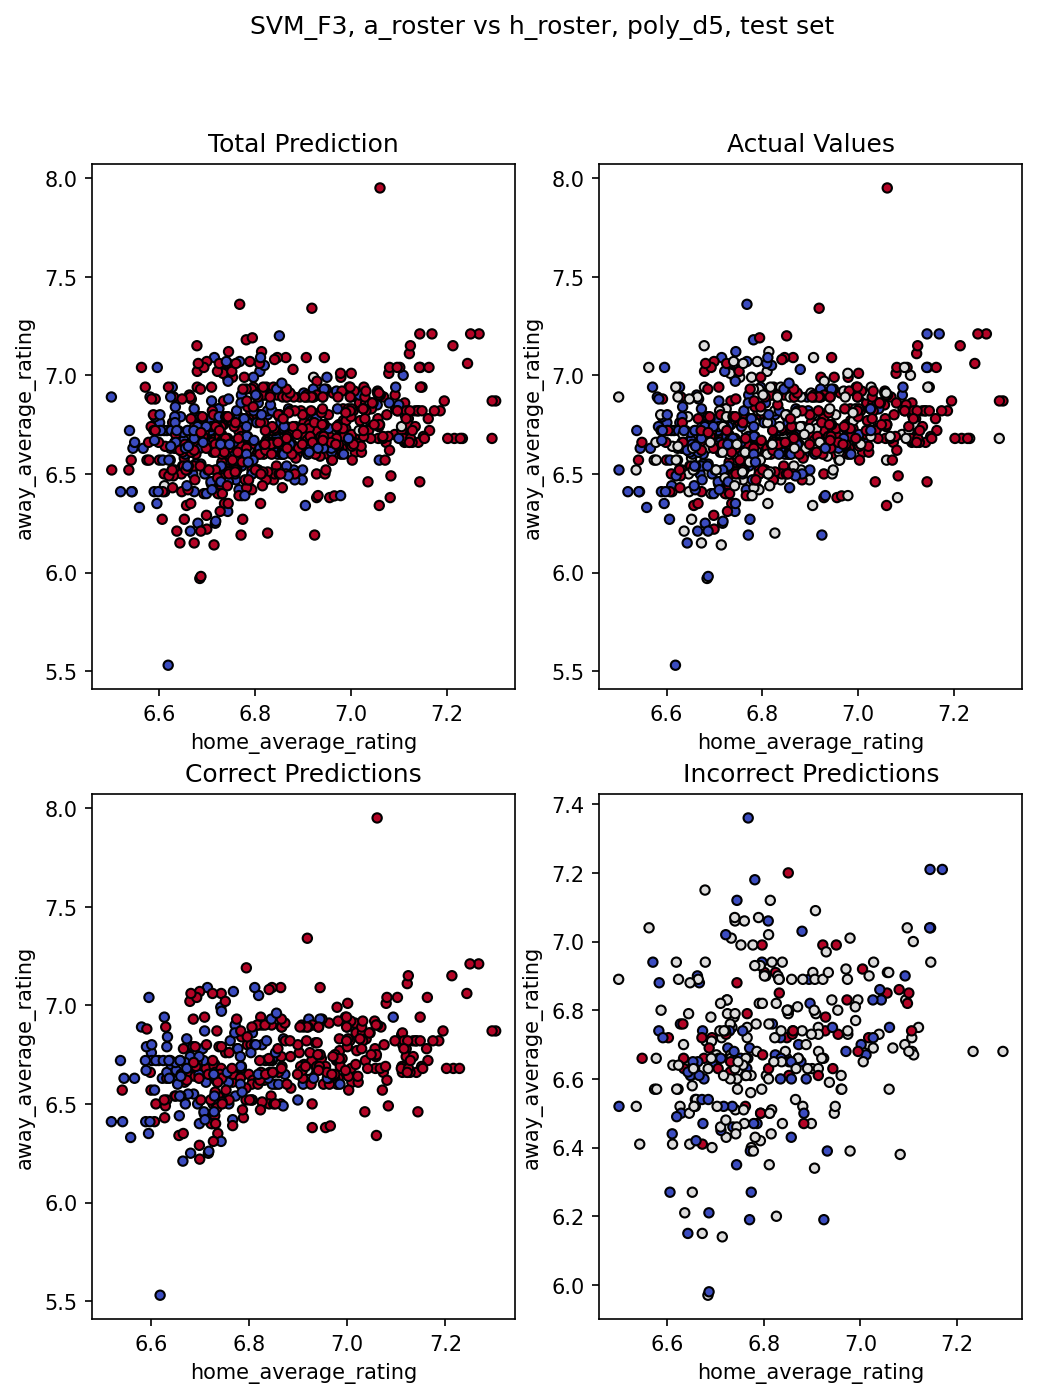

(array([ 0., -1., -1.,  1.,  0.,  1., -1.,  1., -1.,  0.,  1.,  0., -1.,
        -1.,  1.,  1.,  1.,  1., -1.,  0., -1.,  1.,  0.,  1.,  1.,  1.,
         1., -1., -1.,  0.,  1.,  1., -1.,  1.,  0., -1.,  0.,  0.,  1.,
         1., -1., -1., -1.,  0.,  0., -1.,  1.,  1., -1.,  1.,  1.,  0.,
         1.,  0., -1.,  1.,  0., -1.,  1.,  1.,  0.,  1., -1.,  0.,  0.,
         1.,  0.,  1.,  1.,  1.,  0., -1.,  1.,  1.,  1.,  0.,  1.,  1.,
         1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  0.,  1.,  0., -1.,  1.,
        -1.,  0.,  1.,  1., -1.,  1.,  1.,  1.,  0.,  1.,  1., -1., -1.,
        -1.,  1.,  1., -1.,  0.,  0.,  1.,  0.,  0.,  1.,  1., -1.,  1.,
         1.,  1., -1.,  0., -1.,  1.,  1.,  0.,  1., -1.,  1., -1., -1.,
        -1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0., -1.,  0.,  1.,  0.,
         1.,  0.,  0.,  1.,  0.,  0., -1.,  1.,  1., -1., -1.,  0.,  1.,
        -1.,  0., -1.,  0.,  1., -1., -1.,  0., -1.,  1.,  0.,  1.,  1.,
         1.,  1.,  1.,  1., -1.,  1.,  0.,  1.,  1.

In [6]:
# Cell 6: Run SVMs
# RBF Kernel
plot_SVM(x0_train, x1_train, 'rbf', x_train, y_train, x_train, y_train,
         title='SVM_F3, a_roster vs h_roster, rbf, training set')
plot_SVM(x0_test, x1_test, 'rbf', x_test, y_test, x_train, y_train,
         title='SVM_F3, a_roster vs h_roster, rbf, test set')

# Linear Kernel (now fast)
plot_SVM(x0_train, x1_train, 'linear', x_train, y_train, x_train, y_train,
         title='SVM_F3, a_roster vs h_roster, linear, training set')
plot_SVM(x0_test, x1_test, 'linear', x_test, y_test, x_train, y_train,
         title='SVM_F3, a_roster vs h_roster, linear, test set')

# Polynomial Kernel degree=5
plot_SVM(x0_train, x1_train, 'poly', x_train, y_train, x_train, y_train, n_poly=5,
         title='SVM_F3, a_roster vs h_roster, poly_d5, training set')
plot_SVM(x0_test, x1_test, 'poly', x_test, y_test, x_train, y_train, n_poly=5,
         title='SVM_F3, a_roster vs h_roster, poly_d5, test set')
